In [80]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl

import os 
import json

RANDOM_SEED = 972915
rng = np.random.default_rng(RANDOM_SEED)
np.set_printoptions(2)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 15)
plt.rcParams["figure.figsize"] = (15,5)

In [4]:
# utilities 

def plotter(history, title = "", file_path = None):
  number = len(history.history["loss"])
  plt.plot(history.history["binary_accuracy"], label = "Training Accuracy")
  plt.plot(history.history["val_binary_accuracy"], label = "Validation Accuracy")
  plt.xticks(ticks = np.range(number))
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.grid(True)
  plt.title(title)
  if file_path:
    plt.savefig(file_path)

def hankel_transform(ts, rows, columns):
  return np.stack([ts[idx: idx + rows] for idx in range(columns)], axis = -1)

def reverse_hankel_transform(arr):
  arr_ = arr[::-1].copy()
  return np.array([arr_.diagonal(i).mean() for i in range(-arr_.shape[0] + 1, arr_.shape[1])])

## Data 

#### Empirical Data

In [162]:
data = pd.read_csv("GDP.csv")

data = data.loc[data["Country Name"].isin(["Australia", "Brazil"])].copy()
data = data.drop(columns = ["Country Code", "Indicator Name", "Indicator Code"]).set_index("Country Name").T.copy()

data.index = pd.to_datetime(data.index).year
data.index.name = "Year"
data.columns.name = "Country"

data = data.loc[data.index[:-1], ["Australia"]].copy()
data["Australia"] /= 1e10

In [163]:
# config

enum = {'rows': int(len(data) * 0.2),
        'effective_rank': int(len(data) * 0.2),
        "size": 128}
enum.update({'columns': len(data) - enum["rows"] + 1})

In [164]:
# interpolation 

data_missing = data.copy()
mask = data.index % 5
data_missing[mask.isin((0,1,2,3))] = np.NaN
data_matrix = hankel_transform(data_missing["Australia"].values, enum["rows"], enum["columns"])

In [165]:
# extrapolation

# year = 2014
# data_missing = data.copy()
# mask = data.index > year
# data_missing[mask] = np.NaN
# data_matrix = hankel_transform(data_missing["Australia"].values, enum["rows"], enum["columns"])

In [166]:
X = np.ones((enum["size"], 1))

mask = np.isnan(data_matrix.T.flatten())
mask = np.logical_not(mask)
mask = mask.astype(float)

y = data_matrix.T.flatten()
y[np.isnan(y)] = 0.0
y = np.tile(y, reps = (enum["size"], 1))

### Synthetic Data

In [55]:
shape = (200, 100)
rank = 2
missing = int(0.8 * shape[0] * shape[1])

row_data = rng.normal(size = (rank, shape[0]))
col_data = rng.normal(size = (rank, shape[1]))
data = row_data.T @ col_data

In [56]:
data = data.flatten()
data[rng.choice(np.arange(shape[0] * shape[1]), size = missing, replace = False)] = np.NaN
data = data.reshape(shape)

In [57]:
X = np.ones((enum["size"], 1))

mask = np.isnan(data.T.flatten())
mask = np.logical_not(mask)
mask = mask.astype(float)

y = data.T.flatten()
y[np.isnan(y)] = 0.0
y = np.tile(y, reps = (enum["size"], 1))

## Model 

In [167]:
class Imputer(tfk.Model):
  def __init__(self, shape, rank, regularization, **kwargs):
    super(Imputer, self).__init__(**kwargs)
    self.model = tfk.models.Sequential([tfkl.InputLayer(input_shape = (1,)),
                                        tfkl.Dense(units = shape[1] * rank,
                                                   activation = tfk.activations.linear,
                                                   use_bias = False,
                                                   kernel_regularizer = tfk.regularizers.l2(regularization),
                                                   name = "dense"),
                                        tfkl.Reshape((-1,1)),
                                        tfkl.Conv1D(filters = shape[0],
                                                    kernel_size = rank, 
                                                    strides = rank, 
                                                    padding = "valid",
                                                    activation = tfk.activations.linear,
                                                    use_bias = False,
                                                    kernel_regularizer = tfk.regularizers.l2(regularization),
                                                    name = "convolution"),
                                        tfkl.Flatten()])
  
  def call(self, inputs, training = None):
    return self.model(inputs)

In [168]:
class MaskedMeanSquareError(tfk.losses.Loss):
  def __init__(self, mask, loss = "mse", **kwargs):
    super(MaskedMeanSquareError, self).__init__(**kwargs)
    self.mask = mask 
    self.loss = loss

  def call(self, y_true, y_pred, sample_weights = None):
    if self.loss == "mse":
      output = tf.math.squared_difference(y_true, y_pred)
    elif self.loss == "mae":
      output = tf.abs(tf.subtract(y_true, y_pred))
    output = self.mask * output 
    return tf.reduce_mean(output, axis = -1)

## Inference 

In [72]:
# regularization_rows = 1 / (shape[0] * rank)
# regularization_cols = 1 / (rank * shape[1])

regularization = 1 / (shape[0] * shape[1])
model = Imputer(shape = shape, rank = rank, regularization = regularization)
masked_mse = MaskedMeanSquareError(mask = mask)

In [73]:
model.compile(optimizer = tfk.optimizers.Adam(learning_rate = 1e-2),
              loss = masked_mse,
              run_eagerly = False,
              jit_compile = False)

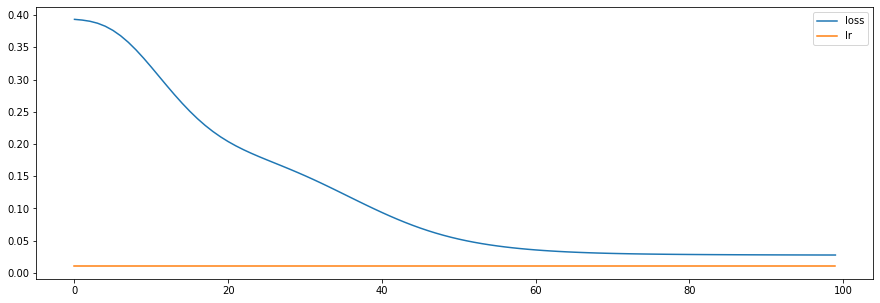

In [74]:
batch_size = 32
epochs = 100

history = model.fit(X,
                    y,
                    batch_size = batch_size,
                    epochs = epochs, 
                    shuffle = True,
                    callbacks = [tfk.callbacks.ReduceLROnPlateau(monitor = "loss", factor = 0.9, patience = 5),
                                 tfk.callbacks.EarlyStopping(monitor = "loss", restore_best_weights = True, patience = 10)],
                    verbose = 0)

pd.DataFrame(history.history).plot();

In [ ]:
tfk.models.save_model(model, "./artifacts/model", overwrite = False)

# model = tfk.models.load_model("./artifacts/model", compile = False)

In [75]:
col_data_hat = model.model.get_layer("dense").weights[0].numpy()
col_data_hat = col_data_hat.reshape(-1,2).T

In [76]:
row_data_hat = np.squeeze(model.model.get_layer("convolution").weights[0].numpy())

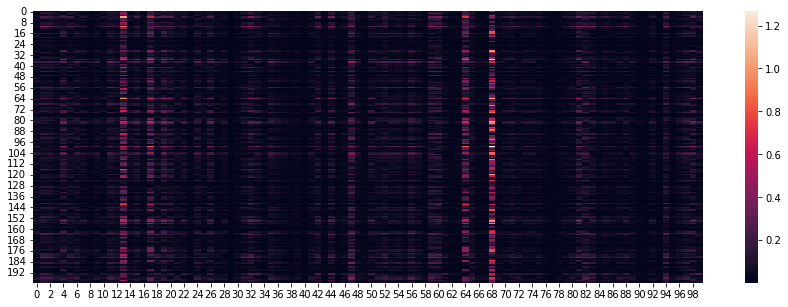

In [82]:
sns.heatmap(np.abs(row_data.T @ col_data - row_data_hat.T @ col_data_hat));

## Application

In [169]:
matrix = hankel_transform(data["Australia"].values, enum["rows"], enum["columns"])
rank = np.linalg.matrix_rank(matrix)
U,S,Vt = np.linalg.svd(matrix)
V = np.transpose(Vt)
matrices = np.array([S[idx] * np.outer(U[:,idx], V[:,idx]) for idx in range(enum["effective_rank"])])

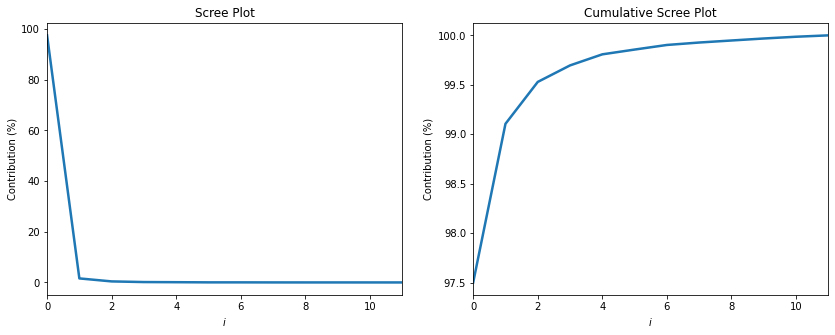

In [170]:
sigma_sumsq = (S**2).sum()
fig, ax = plt.subplots(1, 2, figsize = (14,5))
ax[0].plot(S**2 / sigma_sumsq * 100, lw = 2.5)
ax[0].set_xlim(0, 11)
ax[0].set_title("Scree Plot")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Contribution (%)")
ax[1].plot((S**2).cumsum() / sigma_sumsq * 100, lw = 2.5)
ax[1].set_xlim(0,11)
ax[1].set_title("Cumulative Scree Plot")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Contribution (%)");

### Interpolation

In [212]:
rank = 1
regularization = 1e-5  # 1 / (enum["rows"] * enum["columns"])
model = Imputer(shape = data_matrix.shape, rank = rank, regularization = regularization)
masked_mse = MaskedMeanSquareError(mask = mask, loss = "mse")

In [213]:
model.compile(optimizer = tfk.optimizers.Nadam(learning_rate = 1e-1),
              loss = masked_mse,
              run_eagerly = False,
              jit_compile = False)

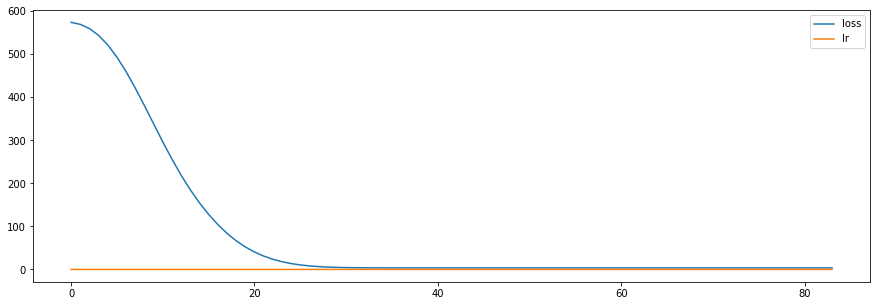

In [214]:
batch_size = 32
epochs = 100

history = model.fit(X,
                    y,
                    batch_size = batch_size,
                    epochs = epochs, 
                    shuffle = True,
                    callbacks = [tfk.callbacks.ReduceLROnPlateau(monitor = "loss", factor = 0.9, patience = 5),
                                 tfk.callbacks.EarlyStopping(monitor = "loss", restore_best_weights = True, patience = 10)],
                    verbose = 0)

pd.DataFrame(history.history).plot();

In [215]:
col_data_hat = model.model.get_layer("dense").weights[0].numpy()
col_data_hat = col_data_hat.reshape(-1, rank).T

row_data_hat = np.reshape(model.model.get_layer("convolution").weights[0].numpy(),
                          newshape = (rank, enum["rows"]))

data_hat = reverse_hankel_transform(row_data_hat.T @ col_data_hat)

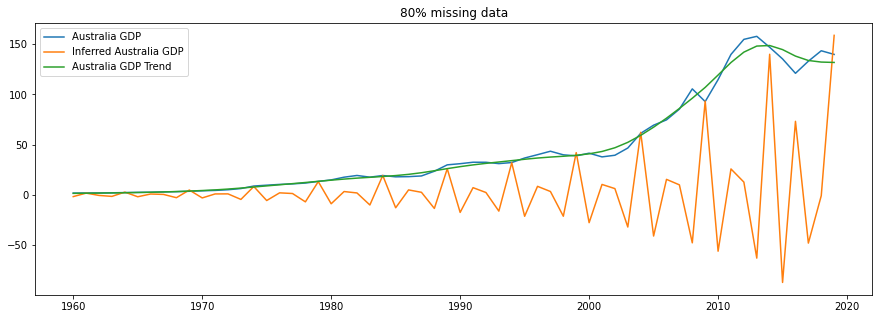

In [216]:
plt.plot(data.index, data, label = "Australia GDP")
plt.plot(data.index, data_hat, label = "Inferred Australia GDP")
plt.plot(data.index, reverse_hankel_transform(sum(matrices[:2])), label = "Australia GDP Trend")

plt.legend()
plt.title("80% missing data");

### Extrapolation

In [ ]:
plt.plot(data.index, data, label = "Australia GDP")
plt.plot(data.index, data_hat, label = "Inferred Australia GDP")
plt.plot(data.index, reverse_hankel_transform(sum(matrices[:2])), label = "Australia GDP Trend")

plt.legend()
plt.axvline(x = year, linestyle = "dashed", color = "purple", alpha = 0.5)
plt.title("80% missing data")
# plt.savefig("./artifacts/interpolation.png")